# Audio recognition

In [1]:
import pathlib
import warnings
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from IPython.display import Audio, display
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from IPython.display import Audio, display

# Suppress warnings
warnings.filterwarnings('always')

## 1. Setup Paths and Validate

In [2]:
# Define paths for training, testing, and output data
base_dir = pathlib.Path.cwd().parent
audios_dir = base_dir / "data" / "mathematical_operations"
training_path = audios_dir / "training"
testing_path = audios_dir / "testing"
output_audio_path = base_dir / "output_audios"

# Validate the existence of directories
if not training_path.exists() or not testing_path.exists():
    raise FileNotFoundError("Training or testing directory not found.")

# Create the output directory if it does not exist
output_audio_path.mkdir(parents=True, exist_ok=True)

print(f"Training Path: {training_path}")
print(f"Testing Path: {testing_path}")
print(f"Output Audio Path: {output_audio_path}")

Training Path: h:\My Drive\UAO_EIA\Curso_7_Procesamiento_Datos_Secuenciales_DL\Modulo1_Procesamiento_de_Series_de_Tiempo\sequential_data_dl_assignment1\data\mathematical_operations\training
Testing Path: h:\My Drive\UAO_EIA\Curso_7_Procesamiento_Datos_Secuenciales_DL\Modulo1_Procesamiento_de_Series_de_Tiempo\sequential_data_dl_assignment1\data\mathematical_operations\testing
Output Audio Path: h:\My Drive\UAO_EIA\Curso_7_Procesamiento_Datos_Secuenciales_DL\Modulo1_Procesamiento_de_Series_de_Tiempo\sequential_data_dl_assignment1\output_audios


## 2. Helper Functions

In [3]:
def load_wav_16k_mono(filename):
    """Load a WAV file and resample to 16kHz mono."""
    file_contents = tf.io.read_file(filename)
    wav, _ = tf.audio.decode_wav(file_contents, desired_channels=1)
    return tf.squeeze(wav, axis=-1).numpy()

In [4]:
def preprocess_wave(wave, sample_rate=16000, duration_sec=3):
    """Truncate or pad waveform and compute the spectrogram."""
    target_length = sample_rate * duration_sec
    wave = wave[:target_length] if len(wave) > target_length else np.pad(wave, (0, target_length - len(wave)), 'constant')
    spectrogram = tf.signal.stft(wave, frame_length=255, frame_step=128)
    return tf.abs(spectrogram).numpy()

In [5]:
def prepare_data(audio_list, label_mapping=None, sample_rate=16000, duration_sec=3):
    """Prepare spectrograms and one-hot encoded labels from audio files."""
    spectrograms, labels = [], []
    for audio_file in audio_list:
        try:
            wave = load_wav_16k_mono(str(audio_file))
            spectrogram = preprocess_wave(wave, sample_rate, duration_sec)
            label = ''.join([char for char in audio_file.stem if not char.isdigit()])
            spectrograms.append(spectrogram)
            labels.append(label)
        except Exception as e:
            print(f"Error processing {audio_file.name}: {e}")

    if label_mapping is None:
        label_set = sorted(set(labels))
        label_map = {label: idx for idx, label in enumerate(label_set)}
    else:
        label_map = label_mapping

    y = np.array([label_map[label] for label in labels])
    y_onehot = tf.keras.utils.to_categorical(y, num_classes=len(label_map))

    return np.array(spectrograms), y_onehot, label_map

## 3. Training Data Exploration

In [6]:
# Map of class names and corresponding indices
class_mapping = {
    'division': 0,
    'multiplicacion': 1,
    'potenciacion': 2,
    'raizcuadrada': 3,
    'resta': 4,
    'suma': 5
}

# List training audio files
training_audio_list = list(training_path.glob("*.wav"))
print(f"Number of training files: {len(training_audio_list)}")

# Generate and save a representative audio for each class
for class_name in class_mapping.keys():
    # Find a file matching the class name in the training data
    class_files = [file for file in training_audio_list if class_name in file.stem]
    
    if class_files:
        # Load the first file found for the class
        representative_file = class_files[0]
        wave = load_wav_16k_mono(str(representative_file))
        
        # Normalize the wave to avoid clipping
        wave = wave / np.max(np.abs(wave))
        
        # Save the wave to a .wav file in the output directory
        output_file = output_audio_path / f"{class_name}.wav"
        tf.audio.encode_wav(tf.convert_to_tensor(wave, dtype=tf.float32)[..., tf.newaxis], sample_rate=16000).numpy()
        
        with open(output_file, "wb") as f:
            f.write(
                tf.audio.encode_wav(
                    tf.convert_to_tensor(wave, dtype=tf.float32)[..., tf.newaxis],
                    sample_rate=16000,
                ).numpy()
            )
        
        print(f"Saved representative audio for class '{class_name}' to {output_file}")
        
        # Display the class name and play the audio
        print(f"Class: {class_name}")
        display(Audio(wave, rate=16000))
    else:
        print(f"No files found for class '{class_name}'")

Number of training files: 78
Saved representative audio for class 'division' to h:\My Drive\UAO_EIA\Curso_7_Procesamiento_Datos_Secuenciales_DL\Modulo1_Procesamiento_de_Series_de_Tiempo\sequential_data_dl_assignment1\output_audios\division.wav
Class: division


Saved representative audio for class 'multiplicacion' to h:\My Drive\UAO_EIA\Curso_7_Procesamiento_Datos_Secuenciales_DL\Modulo1_Procesamiento_de_Series_de_Tiempo\sequential_data_dl_assignment1\output_audios\multiplicacion.wav
Class: multiplicacion


Saved representative audio for class 'potenciacion' to h:\My Drive\UAO_EIA\Curso_7_Procesamiento_Datos_Secuenciales_DL\Modulo1_Procesamiento_de_Series_de_Tiempo\sequential_data_dl_assignment1\output_audios\potenciacion.wav
Class: potenciacion


Saved representative audio for class 'raizcuadrada' to h:\My Drive\UAO_EIA\Curso_7_Procesamiento_Datos_Secuenciales_DL\Modulo1_Procesamiento_de_Series_de_Tiempo\sequential_data_dl_assignment1\output_audios\raizcuadrada.wav
Class: raizcuadrada


Saved representative audio for class 'resta' to h:\My Drive\UAO_EIA\Curso_7_Procesamiento_Datos_Secuenciales_DL\Modulo1_Procesamiento_de_Series_de_Tiempo\sequential_data_dl_assignment1\output_audios\resta.wav
Class: resta


Saved representative audio for class 'suma' to h:\My Drive\UAO_EIA\Curso_7_Procesamiento_Datos_Secuenciales_DL\Modulo1_Procesamiento_de_Series_de_Tiempo\sequential_data_dl_assignment1\output_audios\suma.wav
Class: suma


## 4. Load and Process Data

In [7]:
# Process training data
training_audio_list = list(training_path.glob("*.wav"))
X_train, y_train, label_mapping = prepare_data(training_audio_list)
print(f"Training Data Shape: {X_train.shape}")
print(f"Training Labels Shape: {y_train.shape}")
print(f"Label Mapping: {label_mapping}")

Training Data Shape: (78, 374, 129)
Training Labels Shape: (78, 6)
Label Mapping: {'division': 0, 'multiplicacion': 1, 'potenciacion': 2, 'raizcuadrada': 3, 'resta': 4, 'suma': 5}


In [8]:
# Process testing data
testing_audio_list = list(testing_path.glob("*.wav"))
X_test, y_test, _ = prepare_data(testing_audio_list, label_mapping=label_mapping)
print(f"Testing Data Shape: {X_test.shape}")
print(f"Testing Labels Shape: {y_test.shape}")

Testing Data Shape: (18, 374, 129)
Testing Labels Shape: (18, 6)


In [9]:
# Visualize a sample waveform
sample_file_path = str(training_audio_list[0])
wave = load_wav_16k_mono(sample_file_path)
fig_wave = go.Figure()
fig_wave.add_trace(go.Scatter(y=wave, mode='lines', name='Waveform'))
fig_wave.update_layout(title="Sample Waveform", xaxis_title="Samples", yaxis_title="Amplitude")
fig_wave.show()


In [10]:
# Visualize spectrogram
spectrogram = preprocess_wave(wave)
fig_spec = go.Figure(data=go.Heatmap(z=np.log(spectrogram + 1e-10), colorscale='Viridis'))
fig_spec.update_layout(title="Sample Spectrogram", xaxis_title="Time Bins", yaxis_title="Frequency Bins")
fig_spec.show()

## 5. Model Creation

In [11]:
def create_model_1(input_shape, num_classes):
    """Create and compile the first CNN model."""
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
def create_model_2(input_shape, num_classes):
    """Create and compile the second CNN model with BatchNormalization and Dropout."""
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.4),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
# Model 1
model_1 = create_model_1(input_shape=X_train.shape[1:] + (1,), num_classes=len(label_mapping))
model_1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 372, 127, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 186, 63, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 184, 61, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 92, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 176640)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    22,610,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,629,638 (86.33 MB)

 Trainable params: 22,629,638 (86.33 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Model 2
model_2 = create_model_2(input_shape=X_train.shape[1:] + (1,), num_classes=len(label_mapping))
model_2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 372, 127, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 372, 127, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 186, 63, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 186, 63, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 184, 61, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 184, 61, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 92, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 92, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 176640)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    45,220,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,240,838 (172.58 MB)

 Trainable params: 45,240,646 (172.58 MB)

 Non-trainable params: 192 (768.00 B)

## 6. Train Models

In [15]:
history_1 = model_1.fit(X_train[..., np.newaxis], y_train, validation_data=(X_test[..., np.newaxis], y_test), epochs=20, batch_size=16, verbose=1)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 280ms/step - accuracy: 0.2605 - loss: 5.8406 - val_accuracy: 0.1111 - val_loss: 4.0806
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 210ms/step - accuracy: 0.5426 - loss: 1.5866 - val_accuracy: 0.5556 - val_loss: 1.2173
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 211ms/step - accuracy: 0.9689 - loss: 0.5340 - val_accuracy: 0.7222 - val_loss: 0.9412
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 1.0000 - loss: 0.2373 - val_accuracy: 0.6667 - val_loss: 0.8867
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 1.0000 - loss: 0.0161 - val_accuracy: 0.7222 - val_loss: 0.9189
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 260ms/step - accuracy: 1.0000 - loss: 7.2464e-04 - val_accuracy: 0.7222 - val_loss: 1.2343
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 261ms/step - accuracy: 1.0000 - loss: 8.5819e-05 - val_accuracy: 0.6667 - val_loss: 1.6958
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 1.0000 - loss: 3.5480e-05 - val_accuracy: 0.6111

In [16]:
history_2 = model_2.fit(X_train[..., np.newaxis], y_train, validation_data=(X_test[..., np.newaxis], y_test), epochs=20, batch_size=16, verbose=1)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 674ms/step - accuracy: 0.2406 - loss: 49.4082 - val_accuracy: 0.3889 - val_loss: 4.1183
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 574ms/step - accuracy: 0.6190 - loss: 14.8246 - val_accuracy: 0.7222 - val_loss: 1.4311
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 565ms/step - accuracy: 0.8057 - loss: 5.0295 - val_accuracy: 0.5556 - val_loss: 2.3681
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 557ms/step - accuracy: 0.9214 - loss: 0.9285 - val_accuracy: 0.7222 - val_loss: 2.2908
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 538ms/step - accuracy: 0.8990 - loss: 2.1130 - val_accuracy: 0.7222 - val_loss: 2.5842
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 591ms/step - accuracy: 0.8694 - loss: 3.0569 - val_accuracy: 0.6667 - val_loss: 3.4169
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 676ms/step - accuracy: 0.9897 - loss: 0.6642 - val_accuracy: 0.6667 - val_loss: 3.4239
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 630ms/step - accuracy: 0.9274 - loss: 2.6785 - val_accuracy: 0.6667 - val_los

## 7. Training Visualization

In [17]:
def plot_training_history(history, model_name):
    """Plot training and validation accuracy and loss."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

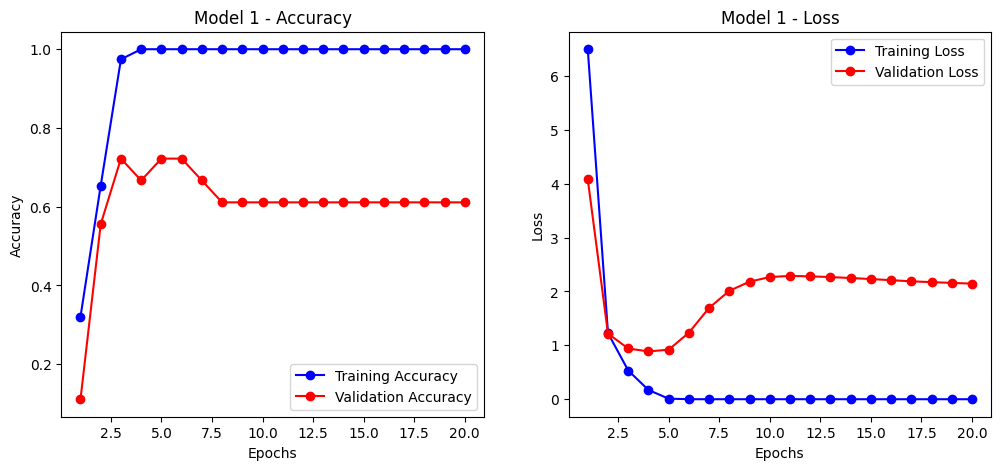

In [18]:
plot_training_history(history_1, "Model 1")

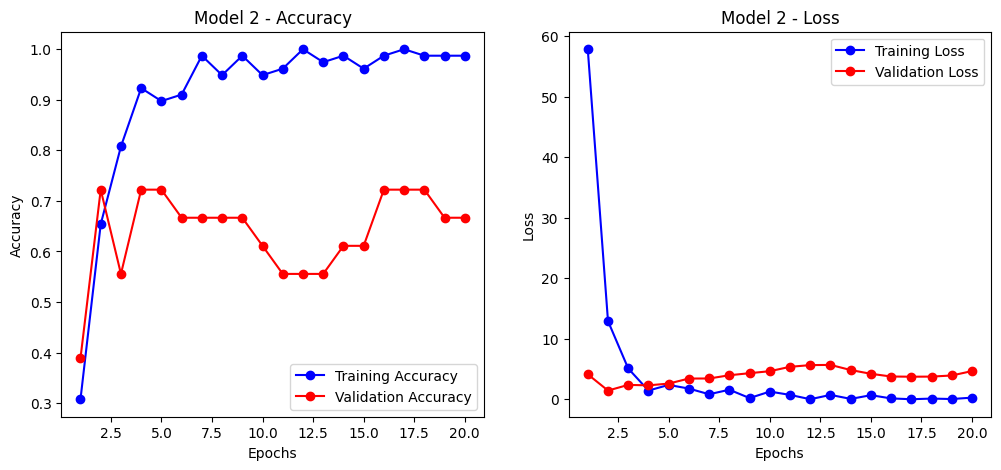

In [19]:
plot_training_history(history_2, "Model 2")

# 8. Model Evaluation

In [20]:
def evaluate_model(model, X_test, y_test, label_mapping):
    """Evaluate the model on testing data and plot confusion matrix."""
    y_test_indices = np.argmax(y_test, axis=1)
    y_pred_probs = model.predict(X_test[..., np.newaxis])
    y_pred_indices = np.argmax(y_pred_probs, axis=1)

    # Compute confusion matrix
    confusion_mtx = confusion_matrix(y_test_indices, y_pred_indices)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(label_mapping.keys()),
                yticklabels=list(label_mapping.keys()))
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Generate classification report
    report = classification_report(y_test_indices, y_pred_indices, target_names=list(label_mapping.keys()), zero_division=0)
    print("Classification Report:")
    print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


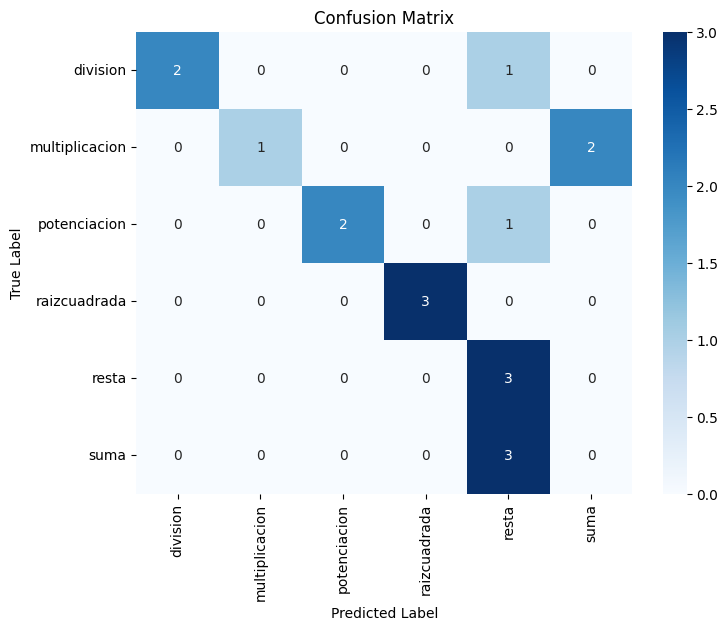

Classification Report:
                precision    recall  f1-score   support

      division       1.00      0.67      0.80         3
multiplicacion       1.00      0.33      0.50         3
  potenciacion       1.00      0.67      0.80         3
  raizcuadrada       1.00      1.00      1.00         3
         resta       0.38      1.00      0.55         3
          suma       0.00      0.00      0.00         3

      accuracy                           0.61        18
     macro avg       0.73      0.61      0.61        18
  weighted avg       0.73      0.61      0.61        18



In [21]:
evaluate_model(model_1, X_test, y_test, label_mapping)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step


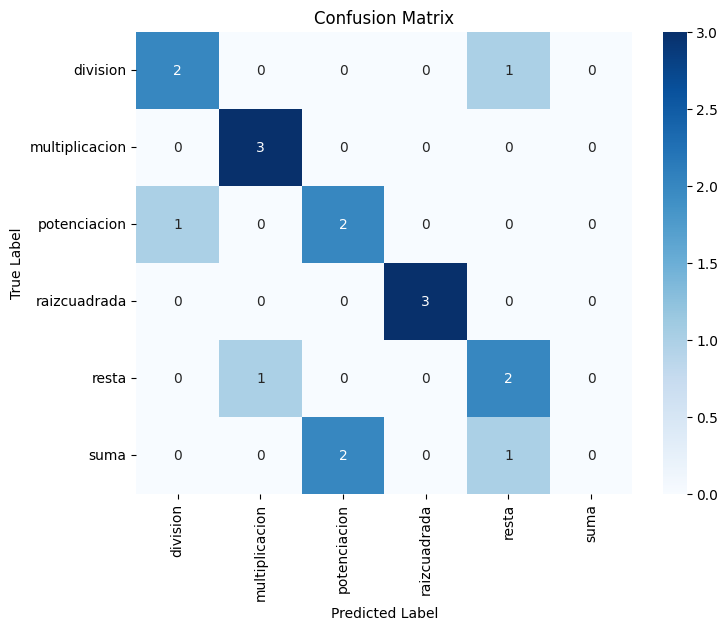

Classification Report:
                precision    recall  f1-score   support

      division       0.67      0.67      0.67         3
multiplicacion       0.75      1.00      0.86         3
  potenciacion       0.50      0.67      0.57         3
  raizcuadrada       1.00      1.00      1.00         3
         resta       0.50      0.67      0.57         3
          suma       0.00      0.00      0.00         3

      accuracy                           0.67        18
     macro avg       0.57      0.67      0.61        18
  weighted avg       0.57      0.67      0.61        18



In [22]:
evaluate_model(model_2, X_test, y_test, label_mapping)